# Provenir AI - Carlo

pyproject.toml content for reproducibility:

```
[tool.poetry]
name = "provenir-case"
version = "0.1.0"
description = ""
authors = ["vitaliset <carlo_lemos@hotmail.com>"]
readme = "README.md"

[tool.poetry.dependencies]
python = "^3.10"
jupyter = "^1.0.0"
scikit-learn = "1.3.1"
pandas = "^2.0.3"
matplotlib = "^3.7.2"
openpyxl = "^3.1.2"
tqdm = "^4.66.1"
lightgbm = "^4.1.0"

[build-system]
requires = ["poetry-core"]
build-backend = "poetry.core.masonry.api"
```

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import TargetEncoder, StandardScaler
from utils import (
    delinquency_curve,
    discrete_lift_curve,
    last_bin_of_discrete_lift_curve,
    ks_curve,
)

pd.set_option("display.max_columns", 500)
plt.rcParams.update({"font.size": 8})

# Exploratory analysis and data quality

In [ ]:
df_raw = pd.read_csv("WorkSample.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59477 entries, 0 to 59476
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   UniqueID                                 59477 non-null  int64  
 1   Loan To Value                            59477 non-null  float64
 2   Branch ID                                59477 non-null  int64  
 3   Age                                      59477 non-null  int64  
 4   Employment Type                          53626 non-null  object 
 5   DisbursalDate                            59477 non-null  object 
 6   State_ID                                 0 non-null      float64
 7   State                                    59477 non-null  object 
 8   Employee_code_ID                         59477 non-null  int64  
 9   Mobile Avl Flag                          59477 non-null  int64  
 10  VoterID Flag                             59477

We can already see that the variables `number_of_active_accounts` and `disbursaldate` are not in the best possible format. Additionally, we have a completely null variable (`state_id`) that I'm going to drop.

The variable `number_of_active_accounts` seems to have some empty values that may indicate 0. When creating any potential models, we can perform an out-of-range imputation for it without significant concerns.

In [ ]:
df = (
    df_raw
    .rename(columns=lambda col: "_".join(col.lower().split()))
    .drop(columns=["state_id"])
    .assign(number_of_active_accounts=lambda df_: df_.number_of_active_accounts.astype(float))
    .assign(disbursaldate=lambda df_: pd.to_datetime(df_.disbursaldate, dayfirst=True))
    .assign(delinquencie_flag=lambda df_: (df_.number_of_delinquencies_last_6_months > 0).astype(int))
)

Let's conduct a brief exploratory analysis of the variables to identify possible errors.

Although we don't have a target variable directly, the information on the number of past delinquencies is a important proxy, and we will want to keep an eye on it.

In [ ]:
id_columns = ["uniqueid"]

continuous_columns = [
    "loan_to_value",
    "age",
    "fico_score",
    "number_of_accounts",
    "number_of_active_accounts",
    "number_of_overdue_accounts",
    "current_balance_amount",
    "number_of_accounts_opened_last_6_months",
    "average_account_age",
    "number_of_inquiries",
]

date_columns = ["disbursaldate"]

categorical_columns = [
    "branch_id",
    "employment_type",
    "state",
    "employee_code_id",
    "mobile_avl_flag",
    "voterid_flag",
]

delinquencie_columns = ["delinquencie_flag", "number_of_delinquencies_last_6_months"]

loan_specific_columns = [
    "sanctioned_amount",
    "disbursed_amount",
    "instalment_amount",
]

assert set(df.columns) == (
    set(id_columns)
    .union(set(loan_specific_columns))
    .union(set(date_columns))
    .union(set(continuous_columns))
    .union(set(categorical_columns))
    .union(set(delinquencie_columns))
)

variables_to_exclude_from_model = []

## EDA: id_columns

For the identification column, we only will determine if customers can repeat.

In [ ]:
df[id_columns].value_counts().head(4)

uniqueid
537409      11
489281       6
417428       1
573060       1
Name: count, dtype: int64

It looks like we have two customers who have applied for credit more than once. It's not a big problem, but we can guarantee that they don't appear simultaneously in the training and testing of any models.

In [ ]:
df.query("uniqueid == 537409").disbursaldate.values

array(['2018-09-26T00:00:00.000000000', '2018-10-25T00:00:00.000000000',
       '2018-08-28T00:00:00.000000000', '2018-10-21T00:00:00.000000000',
       '2018-08-18T00:00:00.000000000', '2018-09-26T00:00:00.000000000',
       '2018-09-23T00:00:00.000000000', '2018-10-26T00:00:00.000000000',
       '2018-08-25T00:00:00.000000000', '2018-09-18T00:00:00.000000000',
       '2018-10-21T00:00:00.000000000'], dtype='datetime64[ns]')

Indeed, it's the case of customers appearing on multiple different dates.

## EDA: continuous_columns

For continuous variables, let's calculate some statistics and examine their distribution using a boxplot and a histogram. This is important to validate whether the range of values is reasonable or not.

Additionally, we'll plot separate histograms for individuals with previous delinquency and those without, to investigate if we can identify any univariate patterns.

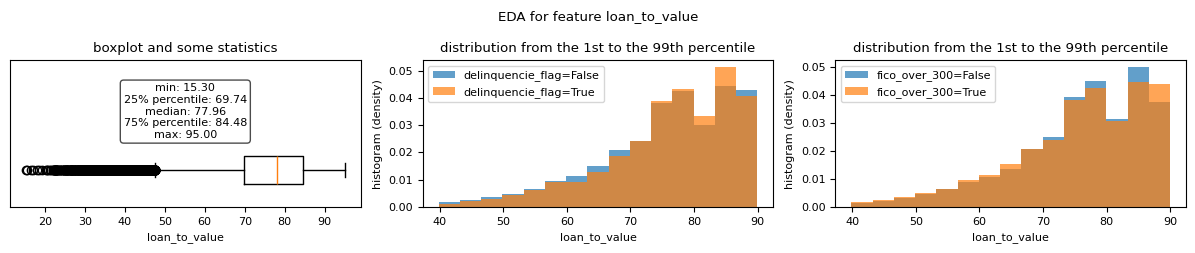

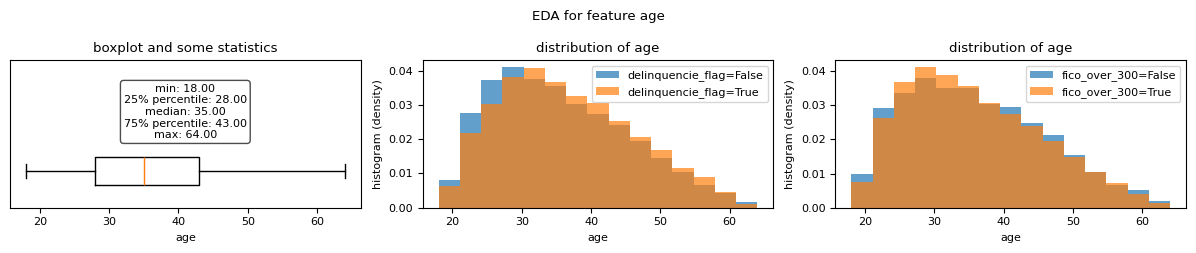

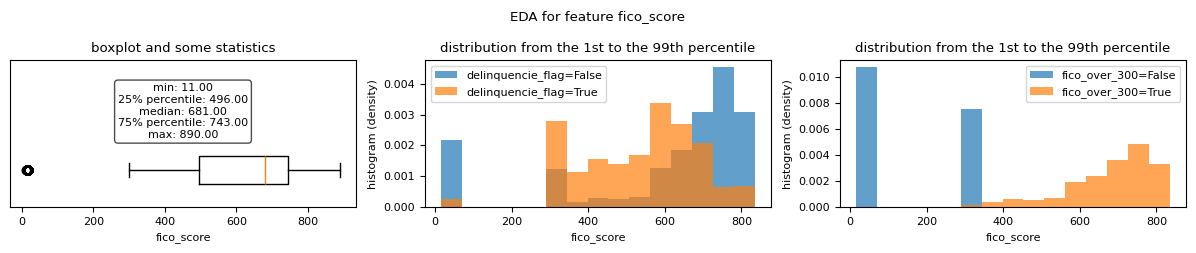

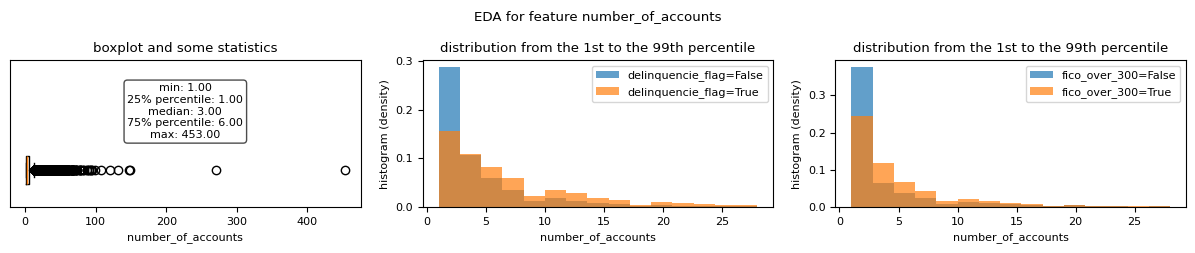

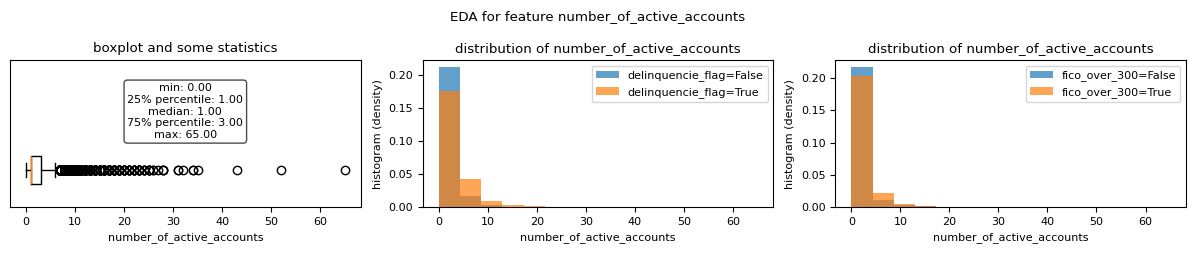

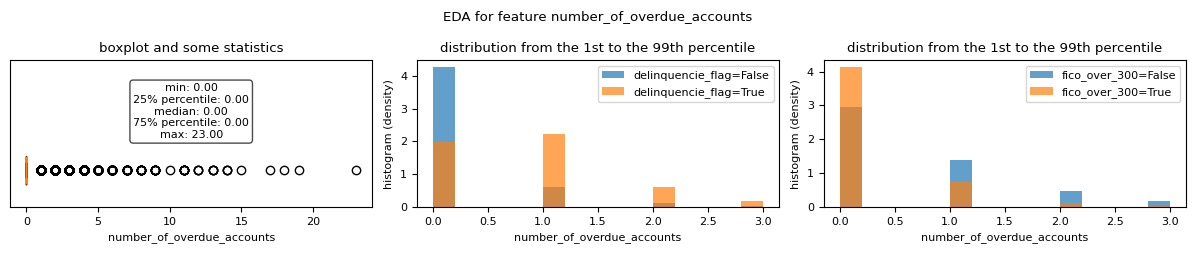

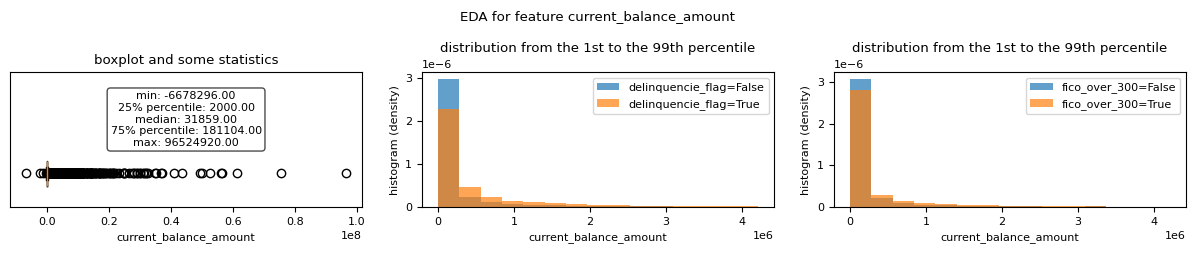

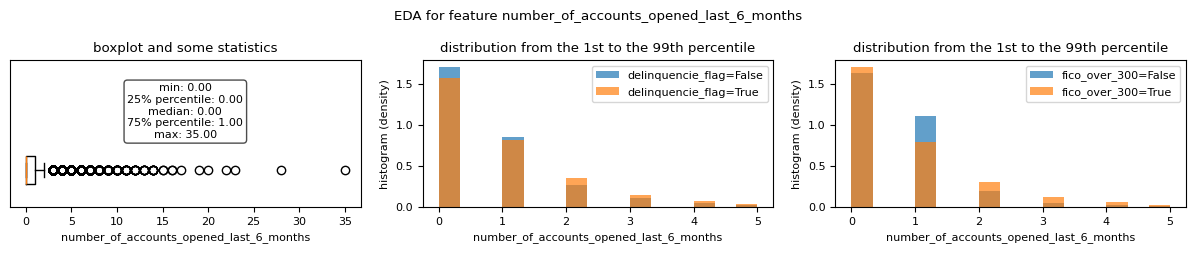

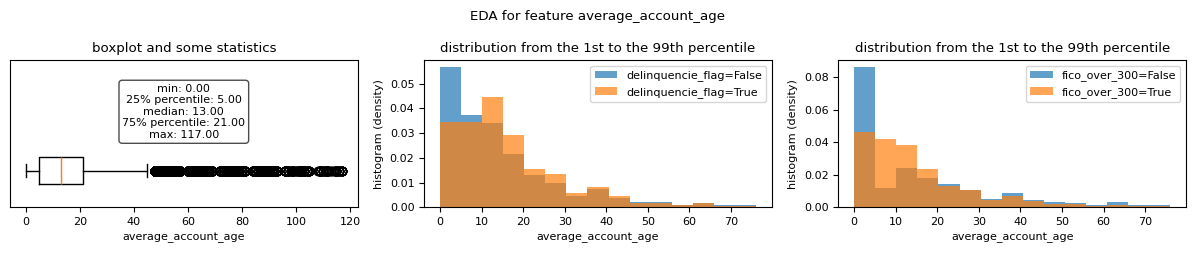

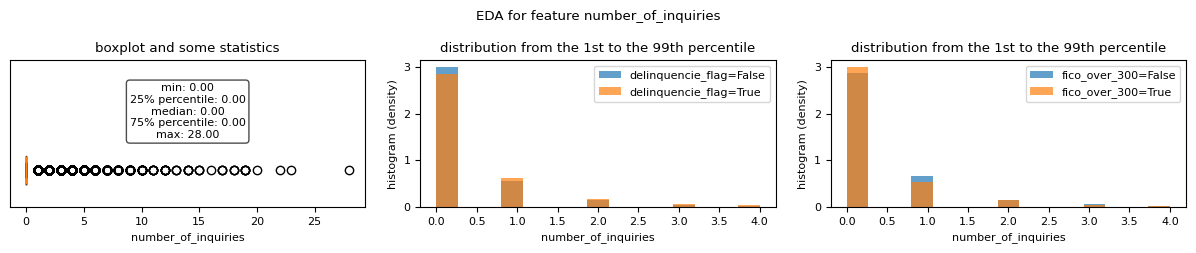

In [ ]:
def has_outliers(data):
    q1, q3 = np.quantile(df[feature], [0.25, 0.75])
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return any((data < lower_bound) | (data > upper_bound))

def plot_boxplot(df, feature, ax):
    ax.boxplot(df[feature].dropna(), vert=False)
    ax.set_yticks([])
    ax.set_ylim([0.8, 1.6])
    ax.set_xlabel(feature)
    bbox_props = dict(
        boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.7
    )
    stats = df[feature].describe()
    stats_text = (
        f"min: {stats['min']:.2f}\n"
        f"25% percentile: {stats['25%']:.2f}\n"
        f"median: {stats['50%']:.2f}\n"
        f"75% percentile: {stats['75%']:.2f}\n"
        f"max: {stats['max']:.2f}"
    )
    ax.text(
        0.5,
        0.65,
        stats_text,
        transform=ax.transAxes,
        ha="center",
        va="center",
        bbox=bbox_props,
    )
    ax.set_title("boxplot and some statistics")
    return ax

def get_bin_values(df, feature, ax, bins):
    has_out = has_outliers(df[feature])
    if has_out:
        qi, qs = np.quantile(df[feature], [0.01, 0.99])
        _, bins_values, _ = ax.hist(
            df.query(f"@qi <= {feature} <= @qs")[feature],
            bins=bins,
            density=True,
            color="C2",
            alpha=0,
        )
    else:
        _, bins_values, _ = ax.hist(
            df[feature], bins=bins, density=True, color="C2", alpha=0
        )
    return bins_values, has_out

def plot_histogram(
    df, feature, ax, bin_values, has_out=False, target="delinquencie_flag"
):
    ax.hist(
        df.query(f"{target} == 0")[feature],
        bins=bin_values,
        density=True,
        color="C0",
        alpha=0.7,
        label=f"{target}=False",
    )
    ax.hist(
        df.query(f"{target} == 1")[feature],
        bins=bin_values,
        density=True,
        color="C1",
        alpha=0.7,
        label=f"{target}=True",
    )
    ax.set_xlabel(feature)
    ax.set_ylabel("histogram (density)")
    ax.legend()
    if has_out:
        ax.set_title(f"distribution from the 1st to the 99th percentile")
    else:
        ax.set_title(f"distribution of {feature}")
    return ax

def eda_per_continuous_feature(df, feature, bins=10):
    fig, ax = plt.subplots(ncols=3, figsize=(12, 2.5))

    plot_boxplot(df, feature, ax[0])
    bins_values, has_out = get_bin_values(df, feature, ax[1], bins=bins)
    plot_histogram(df, feature, ax[1], bin_values=bins_values, has_out=has_out)

    df_fico = df.assign(fico_over_300=lambda df_: (df_.fico_score > 300).astype(int))
    bins_values_fico, has_out_fico = get_bin_values(df_fico, feature, ax[2], bins=bins)
    plot_histogram(
        df_fico,
        feature,
        ax[2],
        bin_values=bins_values_fico,
        has_out=has_out_fico,
        target="fico_over_300",
    )

    fig.suptitle(f"EDA for feature {feature}")
    plt.tight_layout()

for feature in continuous_columns:
    eda_per_continuous_feature(df, feature, bins=15)

Some conclusions from this univariate analysis:

- The range of the variables seems appropriate. There are no very strange values given the concept of the variables, except for `average_account_age`, which appears to be some measure of dispersion around the actual age. I don't feel comfortable using this variable without understanding the concept, so I'll exclude it.

- Variables like `number_of_overdue_accounts`, `number_of_accounts`, `number_of_active_accounts`, `current_balance_amount`, and `average_account_age` seem to provide good indicators of delinquency, but they are complex to evaluate since they are bureau variables, possibly including leakage of the "target" we are using. Other useful information includes the `fico_score`, which is naturally trained for this purpose.

- The most relevant variables for identifying a good payer are also related to a `fico_score < 300` (because the `fico_score` is an estimate of delinquency). However, it's interesting to understand some phenomena that the description of `fico_score` tells us: the distribution of people with `fico_score < 300` is related to `number_of_active_accounts`, indicating that these individuals may be financially excluded. It would be interesting, for example, to apply some rejected analysis technique if we assume that these people have limited access to credit.

In [ ]:
variables_to_exclude_from_model += ["average_account_age"]

## EDA: date_columns

The presence of dates suggests a way to split the dataset into training and testing sets if we want to perform some form of predictive analysis. This temporal split can help us assess the model's performance on data from dates it hasn't seen before, which is crucial for predictive modeling tasks.

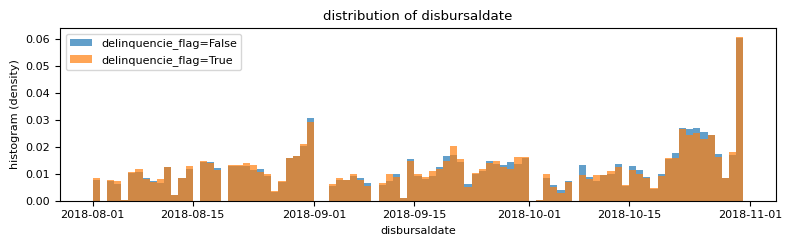

In [ ]:
def eda_per_date_feature(df, feature):
    fig, ax = plt.subplots(figsize=(8, 2.5))
    plot_histogram(df, feature, ax, (df[feature].max() - df[feature].min()).days)
    plt.tight_layout()

for feature in date_columns:
    eda_per_date_feature(df, feature)

## EDA: categorical_columns

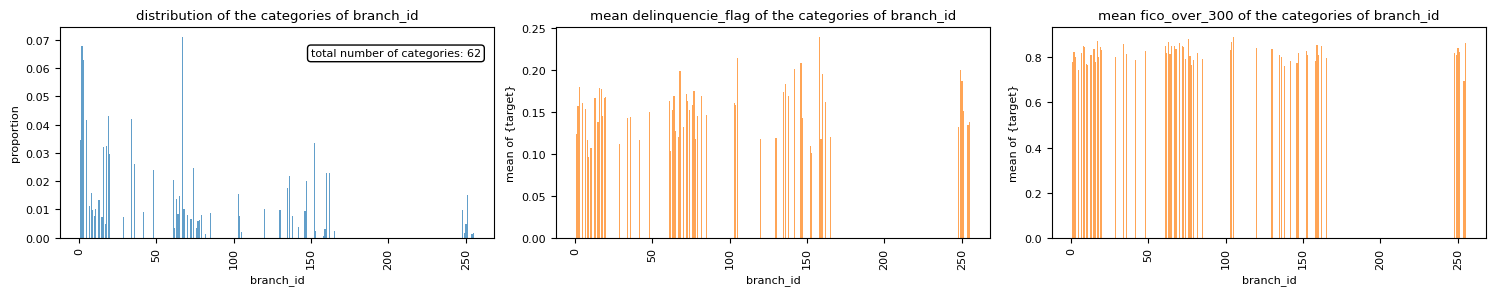

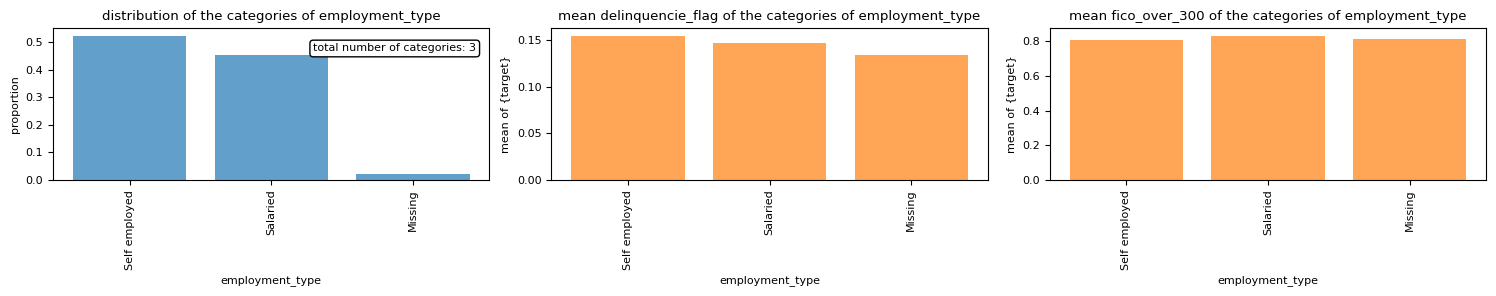

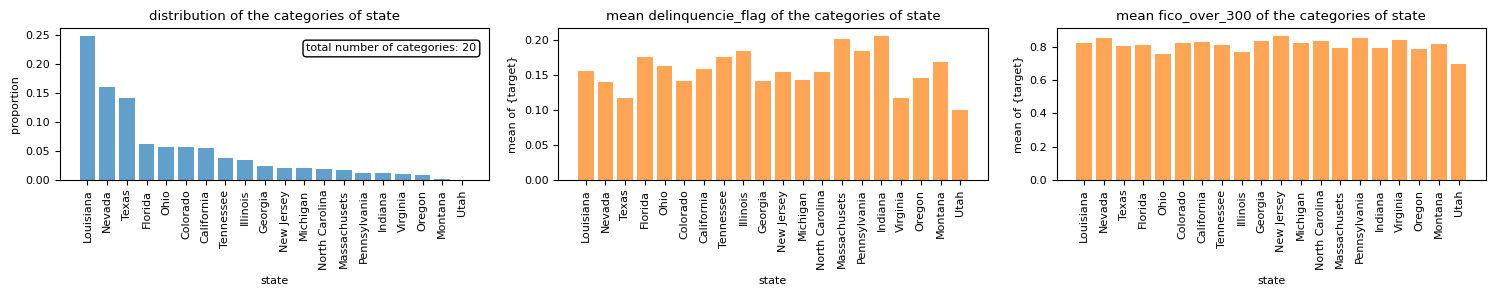

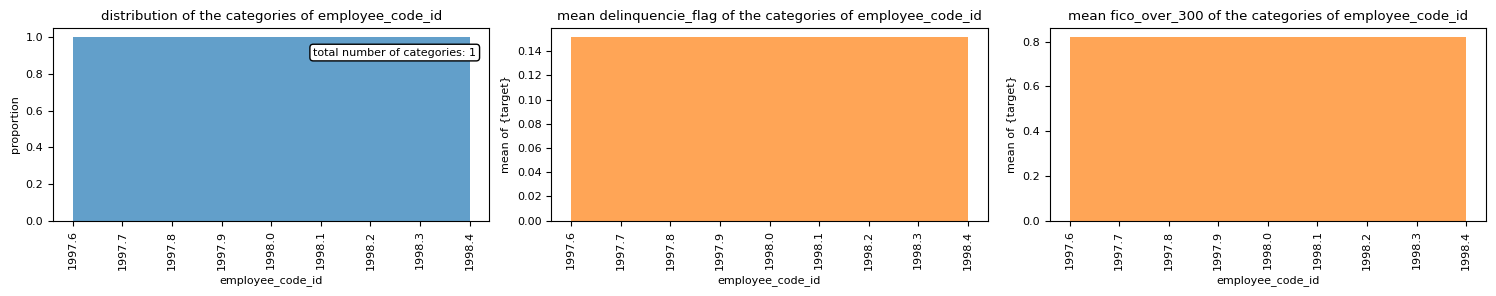

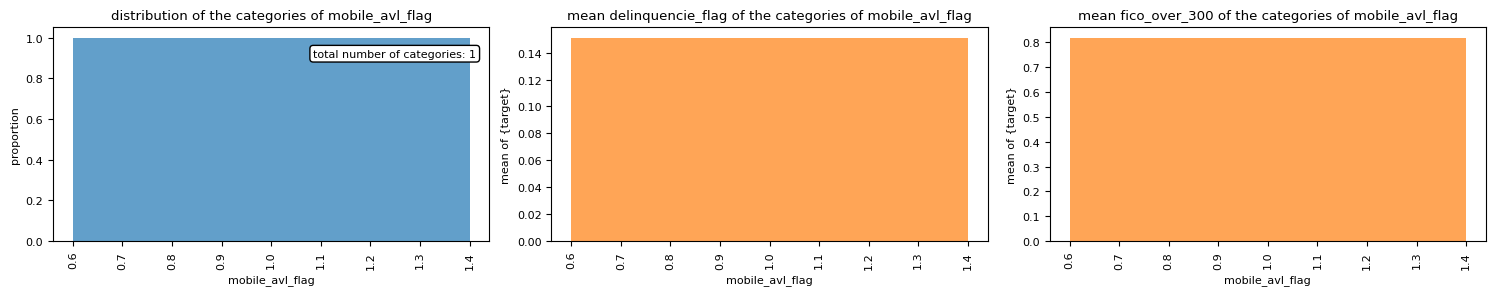

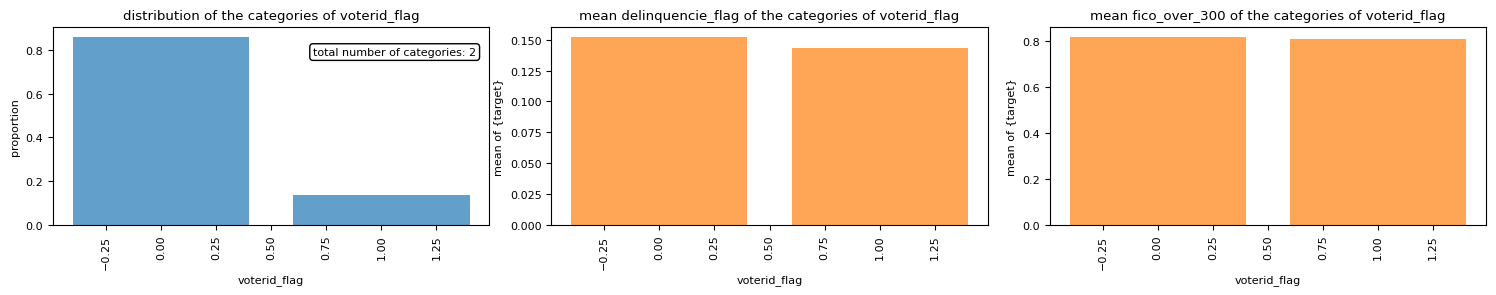

In [ ]:
def plot_category_distribution(df, feature, ax, n_top=False):
    category_counts_full = df[feature].value_counts(normalize=True)
    category_counts = (
        category_counts_full.head(n_top) if n_top else category_counts_full
    )
    ax.bar(category_counts.index, category_counts.values, color="C0", alpha=0.7)
    if n_top:
        ax.set_title(
            f"distribution of the {n_top} most frequent categories of {feature}"
        )
    else:
        ax.set_title(f"distribution of the categories of {feature}")
    ax.set_ylabel("proportion")
    ax.set_xlabel(feature)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    num_categories = len(category_counts_full)
    ax.text(
        0.97,
        0.9,
        f"total number of categories: {num_categories}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
    )
    return ax, list(category_counts.index)

def plot_mean_target_by_category(
    df, feature, ax, selected_cats, target="delinquencie_flag"
):
    category_target_counts = (
        df.loc[lambda df_: df_[feature].isin(selected_cats)]
        .groupby(feature)[target]
        .mean()
        .reindex(selected_cats)
    )
    ax.bar(
        category_target_counts.index,
        category_target_counts.values,
        color="C1",
        alpha=0.7,
    )
    ax.set_title(f"mean {target} of the categories of {feature}")
    ax.set_ylabel("mean of {target}")
    ax.set_xlabel(feature)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    return ax

def eda_per_categorical_feature(df, feature):
    fig, ax = plt.subplots(ncols=3, figsize=(15, 3))
    _, selected_cats = plot_category_distribution(df, feature, ax[0], n_top=False)
    plot_mean_target_by_category(df, feature, ax[1], selected_cats=selected_cats)
    df_fico = df.assign(fico_over_300=lambda df_: (df_.fico_score > 300).astype(int))
    plot_mean_target_by_category(
        df_fico, feature, ax[2], selected_cats=selected_cats, target="fico_over_300"
    )
    plt.tight_layout()

for feature in categorical_columns:
    eda_per_categorical_feature(df, feature)

Analyzing the categorical variables, we can see some constant values that indicate we are examining only people with cell phones and from a specific employer (which is probably incorrect, given that the employment type variable varies, including self-employed people). So let's drop this columns.
Apart from that, we don't see any significant variations concerning past delinquencies or `fico_score < 300`.

In [ ]:
variables_to_exclude_from_model += ["mobile_avl_flag", "employee_code_id"]

## EDA: delinquencie_columns

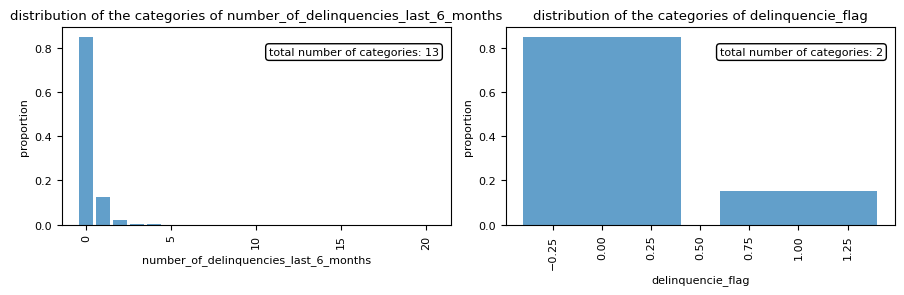

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
plot_category_distribution(df, "number_of_delinquencies_last_6_months", ax[0])
plot_category_distribution(df, "delinquencie_flag", ax[1])
plt.tight_layout()

We have a imbalanced problem when using delinquency as the response variable, but it's not too severe.

In [ ]:
df.delinquencie_flag.mean()

0.15123493114985626

## EDA: loan_specific_columns

We won't be using the variables related to pre-approved/issued loans, so I don't want to clutter the analyses with these variables.

In [ ]:
variables_to_exclude_from_model += loan_specific_columns

df_processed = df.drop(columns=variables_to_exclude_from_model)

# Credit Risk analysis

## Ideal scenario

We would like to use the delinquency information of the loans to build our risk assessment by constructing a classification model.

Since we have information on `sanctioned_amount`, we could assume that people with this value equal to zero (a significant portion) were individuals who applied for credit but were rejected. This could lead us to perform reject inference analysis.

In [ ]:
(df.sanctioned_amount == 0).mean()

0.1856684096373388

## Reasonable scenarios with the proxy target

Since we don't have the real target variable but do have historical delinquency data, it is reasonable to use it as a guideline for our analysis, assuming the hypothesis that people with a similar profile to those with past delinquencies are more likely to have new delinquencies.

The information from `score_fico` appears to be a score calculated by a credit bureau, and using this variable to create categories or ranges seems reasonable. It can provide valuable insights into creditworthiness.

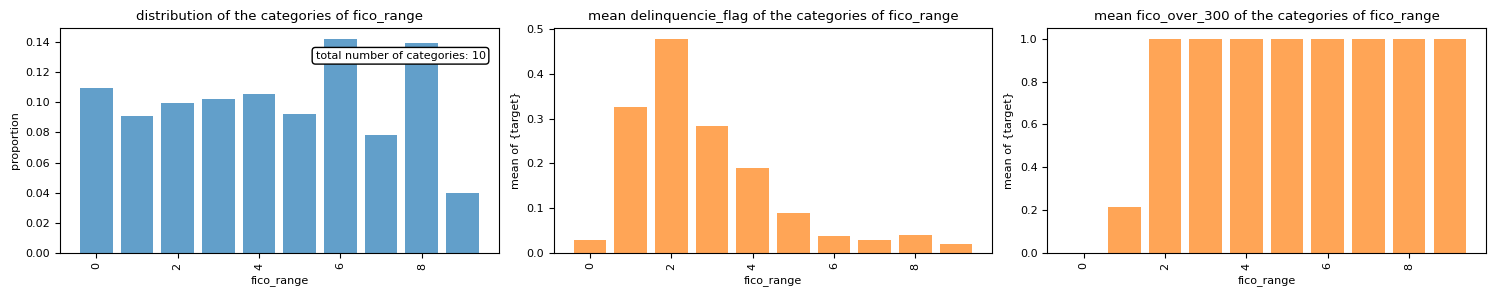

In [ ]:
eda_per_categorical_feature(
    df_processed.assign(fico_range=lambda df_: pd.qcut(df_.fico_score, q=10, labels=False)),
    "fico_range",
)

We can divide it into 10 equally sized groups (although they may not be exactly the same size due to repeated values in the variable). Using the function we constructed earlier, we can see that this variable indeed orders the delinquency flag well.

The issue with this analysis is that the `score_fico` was likely trained on this target variable, so it's not advisable to blindly assume that it will generalize to the future, as there may be some overfitting since part of the credit applicants may have been used to train the model.

It's interesting to note that in the group with `fico_score < 300`, we have an inversion. This is due to the lack of bureau information for this population. Excluding this population, we have a good ordering.

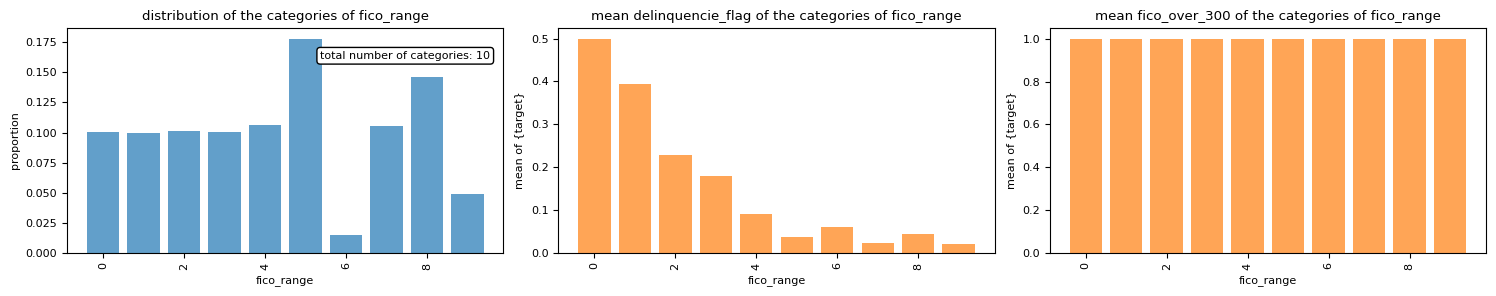

In [ ]:
eda_per_categorical_feature(
    df_processed.query("fico_score > 300").assign(
        fico_range=lambda df_: pd.qcut(df_.fico_score, q=10, labels=False)
    ),
    "fico_range",
)

### Train a model with non leakeageble features

We can analyze, among the available variables, which ones are not posterior to the start of the target variable. Since the target is constructed from `number_of_delinquencies_last_6_months`, the variables that can be confirmed not to leak information are `["age", "employment_type", "state", "voterid_flag"]`, as they don't change significantly within 6 months (except for age, but assuming its continuity, there should be no problem in using it as is).

In [ ]:
def out_of_time_out_sample_train_test_split(df, id_column, test_size=0.2):
    df_train = df.loc[lambda df_: df_.index < (1 - test_size) * df.index.max()].sample(
        frac=1, replace=True, random_state=42
    )
    df_test = (
        df.loc[lambda df_: df_.index >= (1 - test_size) * df.index.max()]
        .sample(frac=1, replace=True, random_state=42)
        .loc[lambda df_: ~df_[id_column].isin(df_train[id_column])]
    )
    return df_train, df_test

df_train, df_test = out_of_time_out_sample_train_test_split(
    df_processed.sort_values("disbursaldate", ascending=True), id_column="uniqueid"
)

def return_X_y(df, cols):
    return df[cols], df.delinquencie_flag

cols_no_leak = ["age", "employment_type", "state", "voterid_flag"]
categorical_features = ["employment_type", "state"]

X_train_no_leak, y_train_no_leak = return_X_y(df_train, cols_no_leak)
X_test_no_leak, y_test_no_leak = return_X_y(df_test, cols_no_leak)

X_test_no_leak_fico_over_300, y_test_no_leak_fico_over_300 = return_X_y(
    df_test.query("fico_score > 300"), cols_no_leak
)

It's interesting to analyze what type of ROCAUC we can expect when considering ROCAUC obtained by `score_fico` for both the entire population and the subpopulation defined by `fico_score >300`.

In [ ]:
roc_auc_score(y_test_no_leak, -df_test.fico_score)

0.6829963800823509

In [ ]:
roc_auc_score(y_test_no_leak_fico_over_300, -df_test.query("fico_score > 300").fico_score)

0.8112862591495784

These values serve as benchmarks for us to analyze the models we construct, and they also provide an indication that, despite the leakage, it doesn't seem like we have a very pronounced overfitting issue of the `fico_score` variable.

In [ ]:
rfc_no_leak = make_pipeline(
    ColumnTransformer(
        [("target", TargetEncoder(random_state=42), categorical_features)],
        remainder="passthrough",
    ),
    RandomForestClassifier(max_depth=15, n_estimators=100, random_state=42),
).fit(X_train_no_leak, y_train_no_leak)

print(f"ROCAUC of full population: {roc_auc_score(y_test_no_leak, rfc_no_leak.predict_proba(X_test_no_leak)[:, 1])}")
print(f"ROCAUC of FICO_SCORE>300 population: {roc_auc_score(y_test_no_leak_fico_over_300, rfc_no_leak.predict_proba(X_test_no_leak_fico_over_300)[:, 1])}")

ROCAUC of full population: 0.5137466262193857
ROCAUC of FICO_SCORE>300 population: 0.5098531382806637


In [ ]:
lr_no_leak = make_pipeline(
    ColumnTransformer(
        [("target", TargetEncoder(random_state=42), categorical_features)],
        remainder="passthrough",
    ),
    StandardScaler(),
    LogisticRegression(random_state=42),
).fit(X_train_no_leak, y_train_no_leak)

print(f"ROCAUC of full population: {roc_auc_score(y_test_no_leak, lr_no_leak.predict_proba(X_test_no_leak)[:, 1])}")
print(f"ROCAUC of FICO_SCORE>300 population: {roc_auc_score(y_test_no_leak_fico_over_300, lr_no_leak.predict_proba(X_test_no_leak_fico_over_300)[:, 1])}")

ROCAUC of full population: 0.5384437470273257
ROCAUC of FICO_SCORE>300 population: 0.5304703247269157


A ROC curve very close to the randomized model suggests that these variables do not have predictive power to perform risk analysis on their own.

### Train a model with possible leak

We can attempt something more ambitious by using additional features that have leakage with the selected target because they are constructed with a temporal intersection with the target and not before it.

In [ ]:
cols_possible_leak = [
    "loan_to_value",
    "age",
    "employment_type",
    "state",
    "voterid_flag",
    "fico_score",
    "number_of_accounts",
    "number_of_active_accounts",
    "number_of_overdue_accounts",
    "current_balance_amount",
    "number_of_accounts_opened_last_6_months",
    "number_of_inquiries",
]

X_train_possible_leak, y_train_possible_leak = return_X_y(df_train, cols_possible_leak)
X_test_possible_leak, y_test_possible_leak = return_X_y(df_test, cols_possible_leak)

X_test_possible_leak_fico_over_300, y_test_possible_leak_fico_over_300 = return_X_y(
    df_test.query("fico_score > 300"), cols_possible_leak
)

In [ ]:
rfc_possible_leak = make_pipeline(
    ColumnTransformer(
        [
            ("impute", SimpleImputer(fill_value=-1), ["number_of_active_accounts"]),
            ("target", TargetEncoder(random_state=42), categorical_features)
        ],
        remainder="passthrough",
    ),
    RandomForestClassifier(max_depth=15, n_estimators=100, random_state=42),
).fit(X_train_possible_leak, y_train_possible_leak)

print(f"ROCAUC of full population: {roc_auc_score(y_test_possible_leak, rfc_possible_leak.predict_proba(X_test_possible_leak)[:, 1])}")
print(f"ROCAUC of FICO_SCORE>300 population: {roc_auc_score(y_test_possible_leak_fico_over_300, rfc_possible_leak.predict_proba(X_test_possible_leak_fico_over_300)[:, 1])}")

ROCAUC of full population: 0.862822928513751
ROCAUC of FICO_SCORE>300 population: 0.853775894002756


In [ ]:
lr_possible_leak = make_pipeline(
    ColumnTransformer(
        [
            ("impute", SimpleImputer(fill_value=-1), ["number_of_active_accounts"]),
            ("target", TargetEncoder(random_state=42), categorical_features)
        ],
        remainder="passthrough",
    ),
    StandardScaler(),
    LogisticRegression(random_state=42),
).fit(X_train_possible_leak, y_train_possible_leak)

print(f"ROCAUC of full population: {roc_auc_score(y_test_possible_leak, lr_possible_leak.predict_proba(X_test_possible_leak)[:, 1])}")
print(f"ROCAUC of FICO_SCORE>300 population: {roc_auc_score(y_test_possible_leak_fico_over_300, lr_possible_leak.predict_proba(X_test_possible_leak_fico_over_300)[:, 1])}")

ROCAUC of full population: 0.787068866007542
ROCAUC of FICO_SCORE>300 population: 0.7844664908723513


In [ ]:
def plot_roc_curve(ax, y, scores):
    roc = roc_auc_score(y, scores)
    fpr, tpr, _ = roc_curve(y, scores)
    ax.plot(
        fpr,
        tpr,
        marker="o",
        markersize=1,
        c="C0",
        label=f"ROCAUC = {(100 * roc).round(2)}%",
    )
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.plot([0, 1], linestyle="dashed", c="C1", label="random model")
    ax.legend()
    ax.set_title("roc curve")
    return ax

def plot_discrete_lift_curve(ax, y, scores):
    last = last_bin_of_discrete_lift_curve(y.values, scores)
    bins, lift = discrete_lift_curve(y.values, scores)
    ax.plot(bins, lift, marker="o", label=f"last decile = {(100 * last).round(2)}%")
    ax.hlines(y.mean(), 0, 9, linestyles="dashed", colors="C1", label="random model")
    ax.set_xlabel("decile of risk")
    ax.set_ylabel("mean of delinquency in the decile")
    ax.legend()
    ax.set_title("discrete lift curve")
    return ax

def plot_delinquency_curve(ax, y, scores):
    approval_rate, default_rate, optimal_rate = delinquency_curve(y, scores)
    index_closest_approval_rate_to_30_percent = np.argmin(
        list(map(lambda x: abs(0.3 - x), approval_rate))
    )
    default_at_30_percent = default_rate[index_closest_approval_rate_to_30_percent]
    ax.plot(
        approval_rate,
        default_rate,
        label=f"default rate at 30% approval = {(100 * default_at_30_percent).round(2)}%",
    )
    ax.hlines(y.mean(), 0, 1, linestyles="dashed", colors="C1", label="random model")
    ax.plot(
        approval_rate, optimal_rate, linestyle="dashed", c="C2", label="perfect model"
    )
    ax.set_xlabel("approval rate")
    ax.set_ylabel("default rate")
    ax.legend()
    ax.set_title("delinquency curve")
    return ax

def plot_ks_curve(ax, y, scores):
    acum1, acum0, thresholds = ks_curve(y, scores)
    arg_threshold_of_ks = np.argmax(np.abs(acum0 - acum1))
    ks = np.max(np.abs(acum0 - acum1))
    ax.vlines(
        thresholds[arg_threshold_of_ks],
        acum0[arg_threshold_of_ks],
        acum1[arg_threshold_of_ks],
        colors="C1",
        linestyles="dashed",
        label=f"ks score = {(100 * ks).round(2)}%",
    )
    ax.plot(thresholds, acum0, c="C0", label="class 0")
    ax.plot(thresholds, acum1, c="C2", label="class 1")
    ax.set_xlabel("threshold")
    ax.set_ylabel("percentage bellow threshold")
    ax.legend()
    ax.set_title("ks curve")
    return ax

def evaluate_plot_model(y, scores):
    fig, ax = plt.subplots(ncols=4, figsize=(15, 3))
    plot_roc_curve(ax[0], y, scores)
    plot_discrete_lift_curve(ax[1], y, scores)
    plot_delinquency_curve(ax[2], y, scores)
    plot_ks_curve(ax[3], y, scores)
    return fig

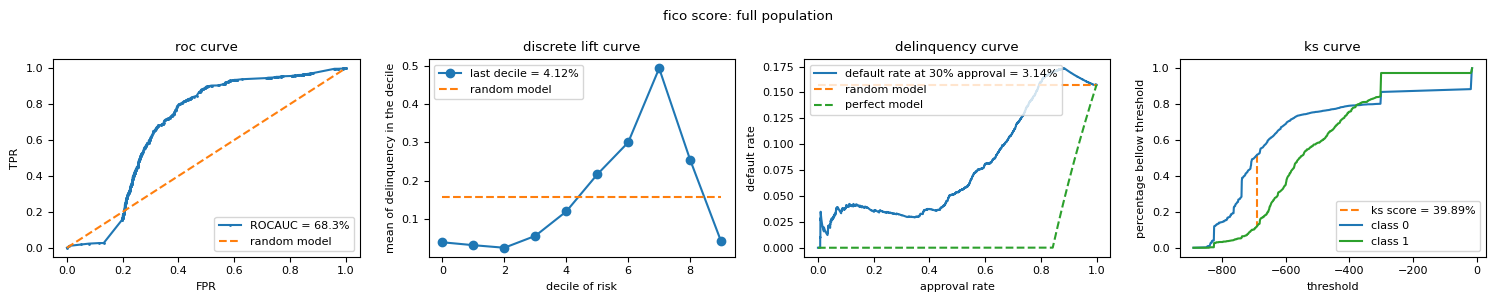

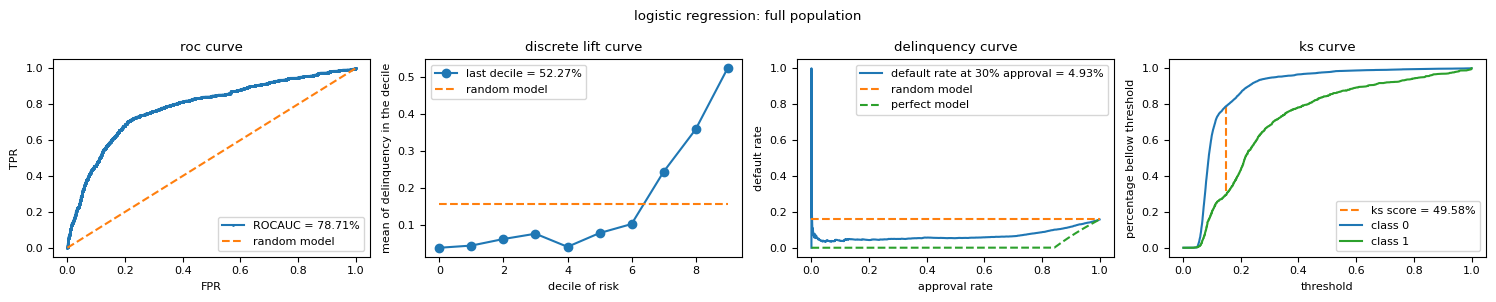

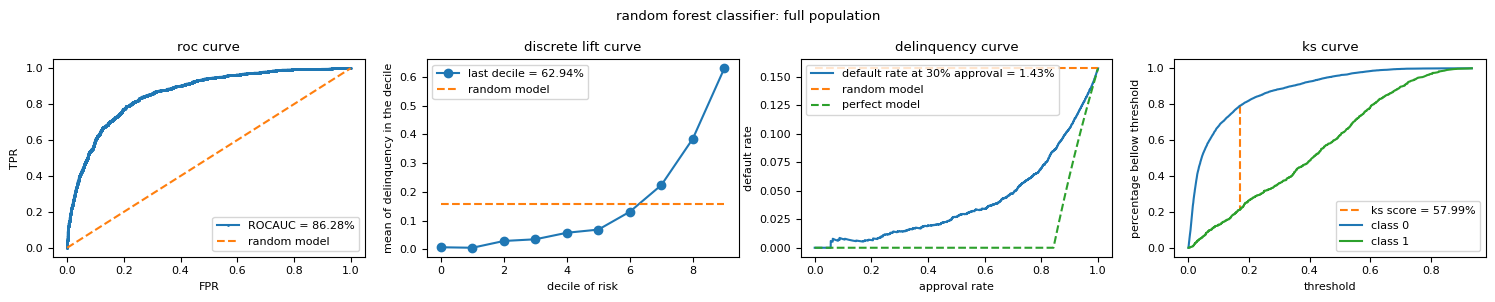

In [ ]:
for scores, model in zip(
    [
        -df_test.fico_score,
        lr_possible_leak.predict_proba(X_test_possible_leak)[:, 1],
        rfc_possible_leak.predict_proba(X_test_possible_leak)[:, 1],
    ],
    ["fico score", "logistic regression", "random forest classifier"],
):
    fig = evaluate_plot_model(y_test_possible_leak, scores)
    fig.suptitle(f"{model}: full population")
    plt.tight_layout()

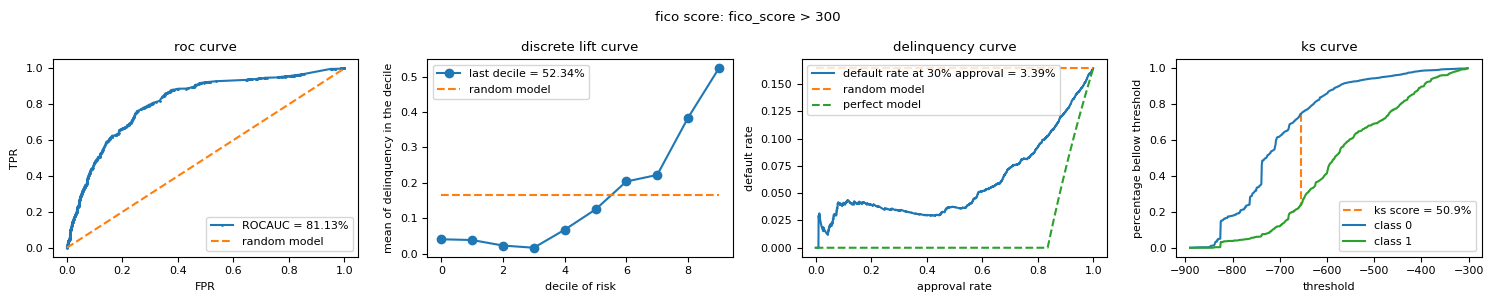

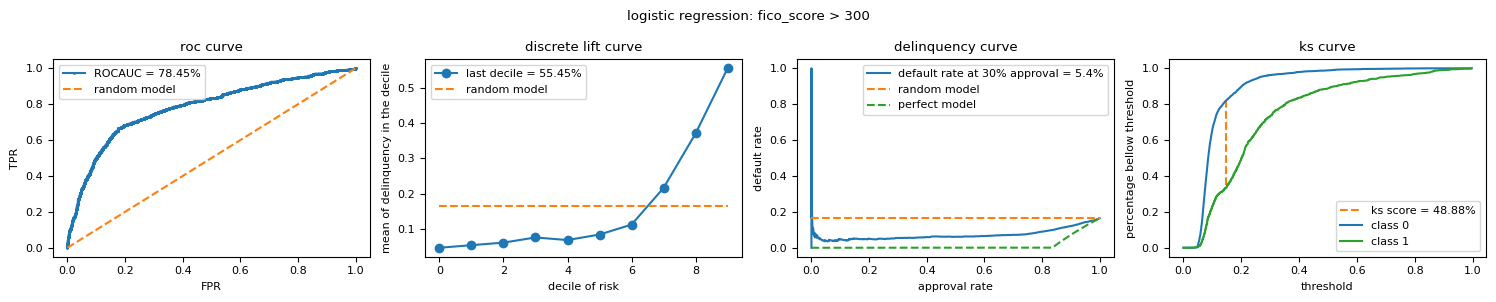

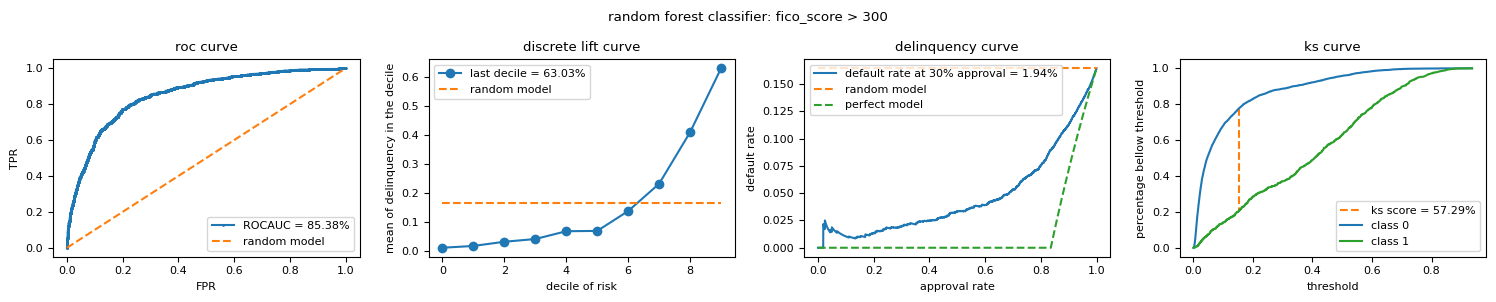

In [ ]:
for scores, model in zip(
    [
        -df_test.query("fico_score > 300").fico_score,
        lr_possible_leak.predict_proba(X_test_possible_leak_fico_over_300)[:, 1],
        rfc_possible_leak.predict_proba(X_test_possible_leak_fico_over_300)[:, 1],
    ],
    ["fico score", "logistic regression", "random forest classifier"],
):
    fig = evaluate_plot_model(y_test_possible_leak_fico_over_300, scores)
    fig.suptitle(f"{model}: fico_score > 300")
    plt.tight_layout()

In the filtered population, the FICO score demonstrates reasonably good performance in the evaluated ranking metrics, while the Random Forest appears to be the best option in all scenarios, assuming the target variable is meaningful.

For this reason, we will briefly assess feature importance aspects of this model using permutation importance.

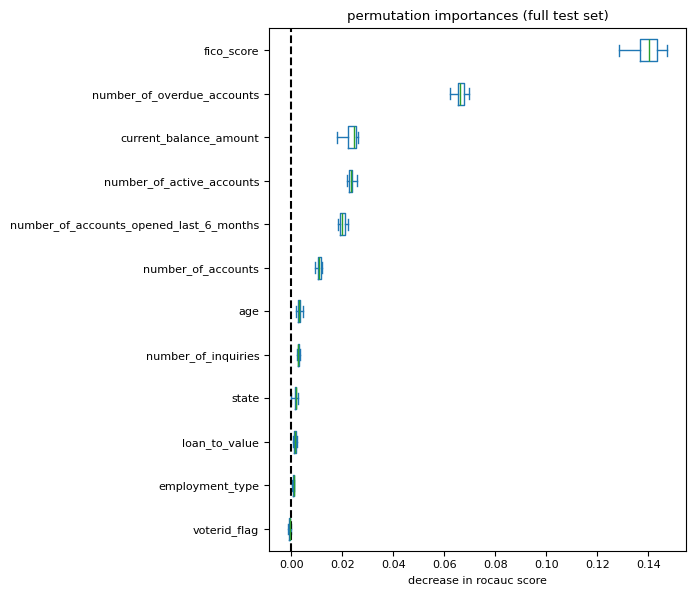

In [ ]:
permutation_importance_result = permutation_importance(
    rfc_possible_leak,
    X_test_possible_leak,
    y_test_possible_leak,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

sorted_importances_idx = permutation_importance_result.importances_mean.argsort()
importances = pd.DataFrame(
    permutation_importance_result.importances[sorted_importances_idx].T,
    columns=X_test_possible_leak.columns[sorted_importances_idx],
)
fig, ax = plt.subplots(figsize=(7, 6))
importances.plot.box(vert=False, ax=ax, whis=10)
ax.set_title("permutation importances (full test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("decrease in rocauc score")
plt.tight_layout()

The model is essentially a refinement of the `fico_score` in combination with some of the other bureau variables that we found to be important in our univariate analysis.

# Guided Clustering

Another alternative could be to construct our groups through clustering since it's a problem explicitly without a target variable. This approach, however, relies somewhat on luck to for the clusters to be related to an individual's credit risk.

Therefore, instead of pursuing this approach, I will use a Forest Embedding technique to create clusters related to our proxy target.

The idea if Forest Embedding is to train a bagging of trees (without going too deep) on a target of interest (in our case, the `delinquency_flag` variable). Since the tree selects relevant variables for the problem, only the useful variables are chosen, and we lose the notion of scale of the variables because of the splits, and proximity is calculated by analyzing the co-occurrence in the leaves of the trees.

For more information, please refer to the LeafNeighbors section of my [blog post on conditional density estimation](https://vitaliset.github.io/conditional-density-estimation/) or [this post on supervised clustering and forest embeddings](https://gdmarmerola.github.io/forest-embeddings/).

In [ ]:
rfc_leaf = make_pipeline(
    ColumnTransformer(
        [
            ("impute", SimpleImputer(fill_value=-1), ["number_of_active_accounts"]),
            ("target", TargetEncoder(random_state=42), categorical_features),
        ],
        remainder="passthrough",
    ),
    RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42),
).fit(X_train_possible_leak, y_train_possible_leak)

X_leaves = rfc_leaf.named_steps["randomforestclassifier"].apply(
    rfc_leaf.named_steps["columntransformer"].transform(X_test_possible_leak)
)

clustering = AgglomerativeClustering(
    metric="hamming", linkage="average", n_clusters=5
).fit(X_leaves)

df_test.assign(cluster=clustering.labels_).groupby("cluster").delinquencie_flag.mean()

cluster
0    0.557252
1    0.323586
2    0.237430
3    0.034608
4    0.090323
Name: delinquencie_flag, dtype: float64

We observe that this guided clustering indeed biases the analysis toward our target, resulting in different delinquency rates for each cluster (the cluster names do not indicate the risk, hence the inversion).

# Conclusions

Based on the analyses conducted, we have identified some relevant segments that can assist in assessing credit risk. In particular, I would like to emphasize the variable `fico_score`, our Random Forest model built using potentially leaked variables and the target proxy, as well as our guided clustering.

The random forest model, in particular, achieved really good performance metrics when we analyzed such as the KS score, the delinquency curve, and ROCAUC.

My suggestion would be to deploy these models on randomly selected subsets of the population and gradually select the best to more population use as we gather the actual target data (or intermediate targets such as pay delay) using a [Multi Armed Bandit](https://gdmarmerola.github.io/ts-for-bernoulli-bandit/) approach.